In [1]:
# load some standard libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math #math fun
import matplotlib.pyplot as plt #plotting
from mpl_toolkits.mplot3d import Axes3D #3d plots
from sklearn.neighbors import NearestNeighbors 

#load weather data that will be used in the script
cityTable     = pd.read_csv('../Example Data/city_attributes.csv')
temperatureDF = pd.read_csv('../Example Data/temperature.csv', index_col=0)

print(type(temperatureDF))
temperatureDF.index = pd.to_datetime(temperatureDF.index)

<class 'pandas.core.frame.DataFrame'>


In [2]:
def takensEmbedding (data, delay, dimension):
    "This function returns the Takens embedding of data with delay into dimension, delay*dimension must be < len(data)"
    if delay*dimension > len(data):
        raise NameError('Delay times dimension exceed length of data!')    
    embeddedData = np.array([data[0:len(data)-delay*dimension]])
    for i in range(1, dimension):
        embeddedData = np.append(embeddedData, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)
    return embeddedData;

In [3]:
def false_nearest_neighours(data,delay,embeddingDimension):
    "Calculates the number of false nearest neighbours of embedding dimension"    
    embeddedData = takensEmbedding(data,delay,embeddingDimension);
    #the first nearest neighbour is the data point itself, so we choose the second one
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(embeddedData.transpose())
    distances, indices = nbrs.kneighbors(embeddedData.transpose())
    #two data points are nearest neighbours if their distance is smaller than the standard deviation
    epsilon = np.std(distances.flatten())
    nFalseNN = 0
    for i in range(0, len(data)-delay*(embeddingDimension+1)):
        if (0 < distances[i,1]) and (distances[i,1] < epsilon) and ( (abs(data[i+embeddingDimension*delay] - data[indices[i,1]+embeddingDimension*delay]) / distances[i,1]) > 10):
            nFalseNN += 1;
    return nFalseNN

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
2015-06-22 00:00:00    291.664
2015-06-22 01:00:00    291.664
2015-06-22 02:00:00    290.279
2015-06-22 03:00:00    290.279
2015-06-22 04:00:00    290.279
                        ...   
2015-08-30 20:00:00    298.500
2015-08-30 21:00:00    299.220
2015-08-30 22:00:00    297.980
2015-08-30 23:00:00    297.350
2015-08-31 00:00:00    296.260
Freq: H, Name: Montreal, Length: 1681, dtype: float64


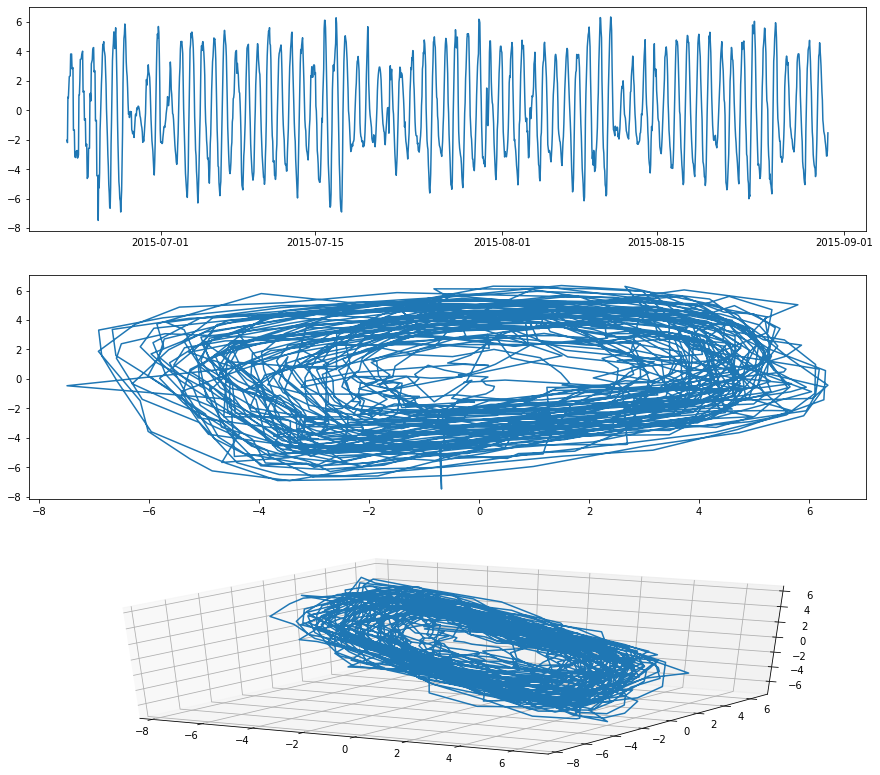

In [4]:
t = pd.date_range(pd.to_datetime('22/6/2015',dayfirst=True),pd.to_datetime('31/8/2015',dayfirst=True),freq='H')
print(type(t))
weatherDataMontreal = temperatureDF.loc[t,'Montreal'];
origSignal = weatherDataMontreal;

print(weatherDataMontreal)

#we are interested in the daily dynamics, so we have to highpass-filter the signal 
#to remove the monthly and yearly dynamics
#apply rolling mean over one day and plot the signal (low pass filter) 
windowSize = 24
lowPassFilteredSignal = weatherDataMontreal.rolling(windowSize, center=True).mean()
# subtract the low pass filtered singal from the original to get high pass filtered signal
weatherDataMontreal = weatherDataMontreal - lowPassFilteredSignal
#remove all NaNs
weatherDataMontreal = weatherDataMontreal.dropna()
#embedd into two dimensions
embeddedWeather = takensEmbedding(weatherDataMontreal,5,2);
#plot the time-series and the embedded one 
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,14));
ax[0].plot(weatherDataMontreal);
ax[1].plot(embeddedWeather[0,:],embeddedWeather[1,:]);
ax[2].axis('off')
#embed into three dimensions
embeddedWeather3 = takensEmbedding(weatherDataMontreal, 6,3);
#plot the 3D embedding
ax = fig.add_subplot(3, 1, 3, projection='3d')
ax.plot(embeddedWeather3[0,:],embeddedWeather3[1,:],embeddedWeather3[2,:]);



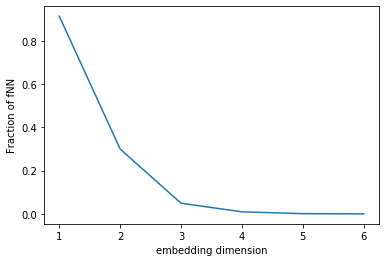

In [5]:
nFNN = []
for i in range(1,7):
    nFNN.append(false_nearest_neighours(weatherDataMontreal,1,i) / len(weatherDataMontreal))
plt.plot(range(1,7),nFNN);
plt.xlabel('embedding dimension');
plt.ylabel('Fraction of fNN');

Text(0.5, 0.92, 'Montreal Weather Data')

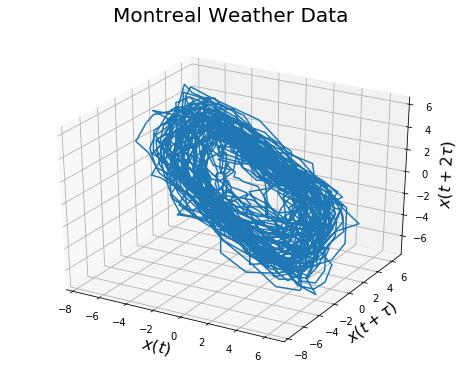

In [10]:
fig = plt.figure()
fig.set_size_inches(8,6)
ax = plt.axes(projection='3d')
ax.plot3D(embeddedWeather3[0,:],embeddedWeather3[1,:],embeddedWeather3[2,:])
ax.set_xlabel('$x(t)$', fontsize=16)
ax.set_ylabel('$x(t+\u03C4)$', fontsize=16)
ax.set_zlabel('$x(t+2\u03C4)$', fontsize=16)
ax.set_title('Montreal Weather Data', fontsize=20, pad=40)